# Learning Objectives

- Understand key abstractions to implement generative AI workflows using `langgraph`

- Implement the following compositional workflows with `langgraph`
    - Sequential Pattern
    - Parallelization Pattern
    - Conditional Pattern

# Setup

In [1]:
!pip install -q langchain-groq==0.3.8 \
                langchain==0.3.20 \
                langgraph==0.3.21 \
                mermaid-python==0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.8/450.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 47.8 MB/s eta 0:00:00


In [3]:
import os
from langchain_groq import ChatGroq
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from mermaid import Mermaid

from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, END, StateGraph

from google.colab import userdata
from IPython.display import Image, display

In [4]:
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [8]:
llm = ChatGroq(
    model="openai/gpt-oss-120b",  # or your model
    groq_api_key=os.environ["GROQ_API_KEY"],
)

# Sequential Pattern

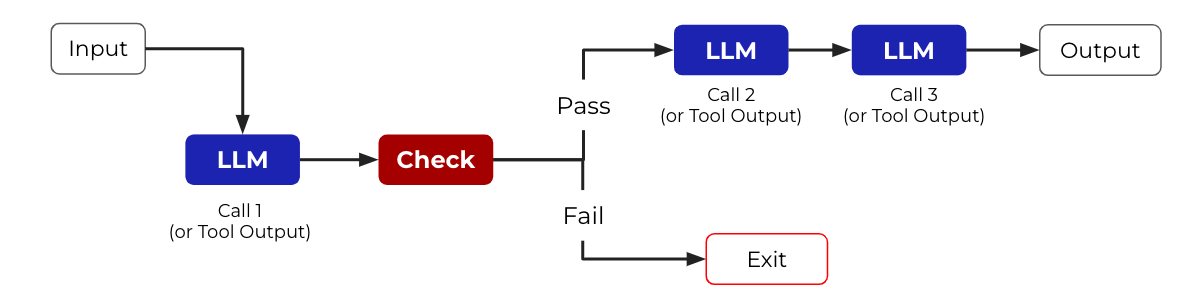

## Business Objective

Implement an automated procedure for document creation based on a chosen topic. The procedure initiates by generating an outline, followed by a validation step to ensure adherence to predefined structural requirements (e.g., presence of introduction, conclusion, and three sections). Full document generation is contingent upon successful outline validation; failure results in process termination and the logging of an error condition.


We implement the automated workflow using several useful abstractions from `langgraph`. The goal is to create an automated workflow (implemented as a "graph") that takes a topic, generates a document outline, validates that outline against specific criteria, and then either generates the full document (if valid) or stops and logs an error (if invalid).

The state of the workflow (topic, outline, validation status, document, errors) is explicitly managed and passed between steps.

In the course of implementation of this pattern, we will also get introduced to several key features of `langgraph`.

LangGraph uses a graph data structure to depict a map or blueprint for a computational process. It defines:
- The Steps (Nodes): These are the individual units of work or computation. Each Python function we define corresponding to each step in the workflow (`generate_outline`, `validate_outline`, `generate_document`) becomes a node in the graph. Each node takes the current state of the workflow as input, performs its specific task (like calling an LLM or checking criteria), and potentially updates the state. Special nodes such as START and END define the start and end points of the workflow.

- The Connections (Edges): These define the possible paths or transitions between the steps (nodes). They dictate the order of execution and the flow of control.
    - Simple Edges (add_edge): These represent direct, sequential links. For example, `workflow.add_edge("generate_outline", "validate_outline")` means that after the `generate_outline` node finishes, the workflow must proceed to the `validate_outline` node next.
    - Conditional Edges (add_conditional_edges): These represent decision points or branches. After a specific node (e.g., the source node, `validate_outline` in our case) finishes, a special function (`should_generate_document`) is called. Based on the result returned by this function (which inspects the current workflow `State`), the graph follows a different edge to the next node (either `generate_document` or the special `END` state). This allows the workflow to dynamically change its path based on intermediate results.

- The State: While not strictly part of the graph structure, the `State` object is fundamental to how the graph operates. It's the data packet that is passed along the edges from node to node. Each node reads the information it needs from the current state and writes its results back into the state, making it available for subsequent nodes or decisions.

In essence, the "graph" in LangGraph is:
- A structured representation of our workflow logic.
- It defines what actions can happen (nodes) and in what order or under what conditions they happen (edges).
- It manages the flow of data (State) between these actions.
- It provides a more organized, modular, and often visualizable way to build complex processes compared to writing deeply nested if/else statements or long sequential function calls.

Let us begin by creating the `State` class that holds all the intermediate portions of the workflow that we want to store.

In [6]:
class State(TypedDict):
    """
    Represents the state of our workflow.
    """
    topic: str                      # Input topic for the document
    outline: str | None             # Generated outline
    outline_validation: str | None  # Result of the outline check ("VALID" or "INVALID: reason")
    document: str | None            # Final generated document
    error_message: str | None       # To store potential errors or reasons for stopping

This class defines the structure of the data that will be passed between different steps (nodes) in our LangGraph workflow. Think of it as the shared memory or blackboard for the graph.

Here we have subclassed a `TypedDict` to define the state. This provides type hinting, making the code easier to understand and maintain. Crucially, when a node function returns a dictionary, LangGraph updates the existing state with the key-value pairs from the returned dictionary. It doesn't replace the whole state unless explicitly told to. Fields are initialized as None where appropriate, indicating they haven't been populated yet.

## Define workflow nodes

**Outline Generation**

In [7]:
def generate_outline(state: State) -> State:
    """Generates a document outline based on the topic."""

    print("---GENERATING OUTLINE---")

    topic = state['topic']

    outline_generation_system_message = """
    You are an expert writer. Generate a clear, structured outline for a document on the following topic.
    Include an introduction, several main points (at least 3), and a conclusion.
    Use appropriate section numbers and subsection numbers in the following format:
    - Main sections to be numbered (e.g., 2)
    - Subsections to use decimal numbering (e.g., 2.1)
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", outline_generation_system_message),
        ("human", "Topic: {topic}")
    ])

    chain = prompt | llm

    response = chain.invoke({"topic": topic})

    return {
        "outline": response.content
    }

This function represents the first active step (a "node") in the workflow. Its purpose is to generate a document outline using an LLM. It retrieves the input topic from the current state, constructs a prompt using ChatPromptTemplate (a LangChain feature for templating LLM inputs), creates a simple LangChain Expression Language (LCEL) chain (prompt | llm), and invokes the chain to get the outline from the LLM.

In LangGraph, any function that takes the `State` object as input and returns a dictionary compatible with the `State` definition can act as a node. This function accesses the necessary information (`topic`) from the input state. The dictionary it returns ({"outline": response.content}) contains the newly generated outline. LangGraph automatically merges this dictionary back into the main workflow state, updating the outline field.

**Outline Validation**

In [9]:
def validate_outline(state: State) -> State:
    """Checks if the outline meets basic criteria."""

    print("---VALIDATING OUTLINE---")

    outline = state['outline']

    if not outline:
         return {
             "outline_validation": "INVALID: No outline provided.", "error_message": "Outline generation failed."
         }

    # --- Validation Criteria ---
    # For this example, we'll use an LLM to check.
    # You could also implement rule-based checks here (e.g., regex, keyword counting).
    # LLM-based validation is more flexible but less deterministic.

    class OutlineValidation(BaseModel):
        """Schema for outline validation result."""
        is_valid: bool = Field(description="Whether the outline meets the criteria (intro, >=3 main points, conclusion).")
        reason: str = Field(description="Reasoning for the validation decision. If invalid, explain why.")

    validation_system_prompt = """
    You are an outline validator. Check if the provided outline meets these criteria:
    1. Has an Introduction section.
    2. Has at least 3 distinct main points/sections.
    3. Has a Conclusion section.
    Respond ONLY with the required JSON format.
    """

    validation_prompt = ChatPromptTemplate.from_messages([
        ("system", validation_system_prompt),
        ("human", "Outline:\n\n{outline}")
    ])

    # Use tool/function calling for structured output
    validation_llm = llm.with_structured_output(OutlineValidation)
    validation_chain = validation_prompt | validation_llm

    try:
        validation_result: OutlineValidation = validation_chain.invoke({"outline": outline})
        print(f"Validation result: {validation_result}")
        if validation_result.is_valid:
            return {"outline_validation": "VALID"}
        else:
            error_msg = f"INVALID: {validation_result.reason}"
            return {"outline_validation": error_msg, "error_message": error_msg}
    except Exception as e:
        print(f"Error during validation: {e}")
        error_msg = f"INVALID: Validation check failed due to error: {e}"
        return {"outline_validation": error_msg, "error_message": error_msg}

This node performs the critical validation step. It receives the state (which should now contain the outline generated by the previous node). It first checks if an outline exists. The core logic uses another LLM call, but this time leverages LangChain's `with_structured_output` method. This method is combined with a Pydantic BaseModel (`OutlineValidation`) to force the LLM to return its validation decision (valid/invalid and a reason) in a specific JSON format, making the result reliable and easy to parse programmatically. It handles potential errors during the LLM call.

One key problem with using LLMs to validate intermediate outputs is the variability in their response. For example, if we prompt the LLM, "Is this outline okay? Does it have an intro, 3 points, and a conclusion?"

The LLM might respond in many ways:
- "Yes, the outline looks good and meets all the criteria."
- "It seems valid. It has an introduction, 4 main points, and a conclusion."
- "No, it's missing a conclusion section."
- "INVALID: The conclusion is absent."

While a human can understand these, it's hard for a program to reliably know:
- Is it definitively VALID or INVALID? (A simple yes/no).
- If INVALID, why? (The specific reason).
- Parsing this free-form text is fragile. A slight change in the LLM's wording could break your code.

The `with_structured_output` method is a powerful LangChain feature designed to solve exactly this problem. Its job is to force the LLM to respond in a specific, predictable format that your program can easily understand.

Here is how it works with `OutlineValidation`:
- Defining the Target Structure (OutlineValidation Schema):

    ```Python
    class OutlineValidation(BaseModel):
        """Schema for outline validation result."""
        is_valid: bool = Field(description="Whether the outline meets the criteria (intro, >=3 main points, conclusion).")
        reason: str = Field(description="Reasoning for the validation decision. If invalid, explain why.")
    ```

    You first define a blueprint for the data you want back. This is the OutlineValidation Pydantic `BaseModel`. It specifies the exact fields (`is_valid`, `reason`), their data types (`bool`, `str`), and, crucially, descriptions.
    These descriptions are not just comments for humans; LangChain uses them to help instruct the LLM!

- Configuring the LLM:

    When you call `llm.with_structured_output(OutlineValidation)`, you're essentially telling LangChain: "Take the base LLM (llm), but modify it so that whenever I call it, it must return data that fits the OutlineValidation structure."

    Behind the scenes, LangChain modifies the instructions sent to the LLM. It effectively adds extra information to your original prompt (`validation_prompt`). The extra instructions are:
    "...when you give me the answer, you MUST format it as a JSON object that looks exactly like this schema:
    {
    "is_valid": <a boolean value - true if it meets criteria, false otherwise>,
    "reason": "<a string explaining your decision, especially if it's invalid>"
    }

    Use the descriptions provided for each field to understand what information to put there. Do NOT add any extra conversational text before or after the JSON."

- Receiving the Structured Output:
    When you invoke the chain (`validation_chain.invoke(...)`), the LLM does its validation task and, thanks to the `with_structured_output` instructions, generates the result as a JSON string (e.g., `{"is_valid": false, "reason": "The outline is missing a conclusion section."}`).
    LangChain automatically intercepts this JSON string.
    It parses the JSON string.
    It uses the parsed data to create an actual Python object – an instance of your `OutlineValidation` class.
    This Python object (`validation_result`) is what gets returned by the `.invoke()` call.

Putting all of this together, similar to the previous node, `validate_outline` takes the state, performs its logic using the outline field, and returns a dictionary to update the state. Depending on the validation outcome (or errors), it updates the outline_validation field with either "VALID" or "INVALID: <reason>" and potentially sets the error_message field. This update is crucial for the conditional logic that follows.


**Document Generation**

In [10]:
def generate_document(state: State) -> State:

    """Generates the full document based on the validated outline."""

    print("---GENERATING DOCUMENT---")

    outline = state['outline']

    topic = state['topic']

    writer_system_prompt = """
    You are a skilled writer. Write a comprehensive document based on the provided outline.
    Expand on each point with clear explanations and examples.
    Use appropriate section numbers and subsection numbers in the following format:
    - Main sections to be numbered (e.g., 2)
    - Subsections to use decimal numbering (e.g., 2.1)
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", writer_system_prompt),
        ("human", "Topic: {topic}\n\nOutline:\n{outline}\n\nPlease write the full document:")
    ])

    chain = prompt | llm

    response = chain.invoke({"topic": topic, "outline": outline})

    print("---DOCUMENT GENERATED---")

    return {
        "document": response.content
    }

This node is responsible for the final document generation if the outline was deemed valid. It accesses both the topic and the validated outline from the state. It uses a different system prompt instructing the LLM to write a full document based on the provided structure. It invokes the LLM chain and gets the final document content.

Like the nodes encountered so far, this function is another standard node. It consumes data (topic, outline) from the state and returns a dictionary (`{"document": response.content}`) to update the state with the final output (document).

## Define conditional logic (the gate)

In [11]:
def should_generate_document(state: State) -> Literal["generate_document", END]:

    """Determines the next step based on outline validation."""
    print("---CHECKING OUTLINE VALIDITY---")

    validation_result = state.get('outline_validation', '') # Use .get for safety

    if validation_result == "VALID":
        print("Outcome: Outline is VALID. Proceeding to document generation.")
        return "generate_document"
    else:
        print(f"Outcome: Outline is INVALID or validation failed ({state.get('error_message', 'Unknown reason')}). Stopping workflow.")
        # Store the reason for stopping if not already set by validation node
        if not state.get('error_message'):
            state['error_message'] = f"Outline validation failed: {validation_result}"
        return END # LangGraph convention for ending the graph execution

This function doesn't perform a primary task like generation or validation; instead, it acts as a router or gate. It inspects the outline_validation field within the current state. Based on whether the validation was "VALID", it decides the next step in the workflow.

This function is specifically designed to be used with `add_conditional_edges`. It takes the state as input. Its return value is critical:
- If it returns a string (e.g., "generate_document"), that string must match the name of a node registered in the graph. LangGraph will route execution to that node next.
- If it returns the special END constant (imported from langgraph.graph), it signals that this path of the workflow should terminate.

## Graph construction

In [12]:
workflow = StateGraph(State)

# Add the nodes
workflow.add_node("generate_outline", generate_outline)
workflow.add_node("validate_outline", validate_outline)
workflow.add_node("generate_document", generate_document)

# Add edges for the sequential flow
workflow.add_edge(START, 'generate_outline')
workflow.add_edge("generate_outline", "validate_outline")

# Add the conditional edge (the gate)
workflow.add_conditional_edges(
    "validate_outline",         # Source node
    should_generate_document   # Function to decide the next step
)

# Add the final edge
workflow.add_edge("generate_document", END)

The above code defines the structure and flow of the workflow using LangGraph's `StateGraph`.

- `StateGraph(State)`: Creates an instance of a stateful graph, telling LangGraph what structure (State) the shared state will have.

- `add_node(name, function)`: Registers each processing function as a node within the graph, associating a unique string name (e.g., "generate_outline") with the actual Python function (generate_outline).

- `add_edge(source_node_name, destination_node_name)`: Defines a direct, unconditional transition between two nodes. Execution flows from the source to the destination. START is a special constant representing the graph's entry point.

- `add_conditional_edges(source_node_name, condition_function)`: This is the core of the branching logic. It specifies that after the `source_node_name` ("validate_outline") finishes, the condition_function (`should_generate_document`) should be called. The condition_function then directs the workflow based on the return value of the condition_function. If it returns "generate_document", the graph proceeds to the node named "generate_document". If it returns END, the graph terminates.

In [13]:
compiled_workflow = workflow.compile()

`compile()`: This method takes the defined nodes and edges and transforms them into an executable CompiledGraph object. This compiled object can then be invoked to run the workflow.

The compiled graph can then be visualized like so (the `mermaid` package might time out, hence an ASCII visualization is provided):

In [16]:
graph = compiled_workflow.get_graph().draw_mermaid()
Mermaid(graph)

In the above figure, dotted lines indicate conditional edges while solid lines indicate direct, unconditional edges.

## Workflow execution

Now we can execute the defined and compiled workflow using the `invoke` method. In the code below, the `invoke` method on the `compiled_workflow` object starts the graph execution. It requires an initial dictionary representing the starting state. In this case, we only need to provide the input topic. LangGraph executes the nodes following the defined edges and conditional logic, passing and updating the State object along the way. The `invoke` call blocks until the graph reaches an END state, and it returns the final State object, which contains all the data accumulated during the run (the generated outline, validation status, final document, or error message).

In [14]:
chosen_topic = "Impact of tariffs on global trade flows"

In [19]:
result = compiled_workflow.invoke({"topic": chosen_topic})

---GENERATING OUTLINE---
---VALIDATING OUTLINE---
Validation result: is_valid=True reason='The outline includes an Introduction (section 1), contains multiple main sections (1‑8, exceeding the minimum of three), and ends with a Conclusion (section 8). All required criteria are satisfied.'
---CHECKING OUTLINE VALIDITY---
Outcome: Outline is VALID. Proceeding to document generation.
---GENERATING DOCUMENT---
---DOCUMENT GENERATED---


Since the final result is a `State` object, we can inspect all the intermediate values stored (e.g., `outline`) along with the final result (i.e., the `document` generated).

In [20]:
print(result['outline'])

**Outline: Impact of Tariffs on Global Trade Flows**

**1. Introduction**  
   1.1. Definition of tariffs and their purpose  
   1.2. Overview of global trade dynamics  
   1.3. Rationale for examining tariff impacts  

**2. Economic Mechanisms of Tariffs**  
   2.1. Price effects on imported goods  
   2.2. Supply‑and‑demand adjustments in exporting and importing countries  
   2.3. Revenue generation versus welfare loss  
   2.4. Interaction with non‑tariff barriers  

**3. Tariffs and Trade Volume Shifts**  
   3.1. Short‑term changes in bilateral trade flows  
   3.2. Long‑term reallocation of production and sourcing patterns  
   3.3. Case studies:  
&nbsp;&nbsp;&nbsp;&nbsp;3.3.1. U.S.–China trade war (2018‑2022)  
&nbsp;&nbsp;&nbsp;&nbsp;3.3.2. EU steel and aluminum tariffs (2021)  
&nbsp;&nbsp;&nbsp;&nbsp;3.3.3. Emerging‑market responses to U.S. agricultural tariffs  

**4. Sector‑Specific Impacts**  
   4.1. Manufacturing and high‑value‑added goods  
   4.2. Agricultural commod

In [21]:
print(result['document'])

**Impact of Tariffs on Global Trade Flows**  
*Prepared as a comprehensive reference document*  

---

## 1. Introduction  

### 1.1. Definition of tariffs and their purpose  

A **tariff** is a tax levied by a national government on goods and services that cross its borders. Tariffs can be expressed as a specific amount per unit (e.g., $0.50 per kilogram) or as an ad‑valorem rate (a percentage of the customs value).  

The principal purposes of tariffs are:  

| Purpose | Typical Rationale | Example |
|---------|-------------------|---------|
| **Revenue generation** | Historically, tariffs were a major source of fiscal income for governments lacking sophisticated tax systems. | 19th‑century United States relied heavily on import duties to fund federal expenditures. |
| **Protection of domestic industries** | By raising the price of imported substitutes, tariffs aim to give domestic producers a price advantage, preserving jobs and encouraging local investment. | The “infant‑industry” 

# Parallelization Pattern

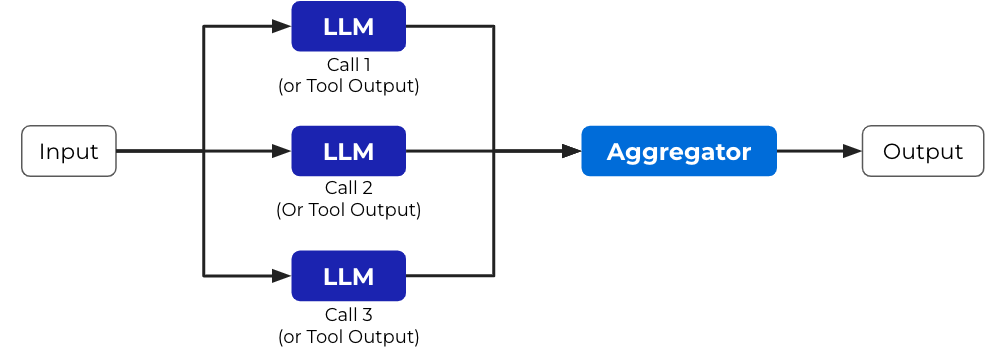

## Business Objective

Develop an automated workflow designed to comprehensively evaluate the quality of generated LLM responses by assessing them against multiple, distinct criteria simultaneously.

A key application for this workflow is standardizing evaluations within customer service operations, specifically addressing frequent scenarios like responding to customer complaints about damaged products - a common task in e-commerce environments. This evaluation aims to ensure consistent quality in critical customer touchpoints.

The workflow will execute evaluations across several core dimensions:

- Clarity: Assessing whether the reply and any proposed resolutions are clear and easily understood by the customer.
- Relevance: Determining if the response directly and effectively addresses the specific problem raised by the customer.
- Safety and Appropriateness: Ensuring the response is free from inappropriate language, blaming tones, or potentially harmful content.

By systematically evaluating responses along these lines, the business can ensure that its automated or LLM-assisted customer interactions consistently meet established quality standards for politeness, helpfulness, and adherence to the brand voice.

Our implementation will involve providing the workflow with the initial prompt given to the LLM and the resulting response. The workflow will then initiate several independent evaluation tasks that run in parallel. Each task employs a dedicated LLM "evaluator" focused on one specific quality dimension (like clarity or relevance). Upon completion of these parallel evaluations, the workflow automatically collects the individual results and generates a consolidated, aggregated evaluation report. Utilizing this parallel execution model is crucial for achieving efficiency in the evaluation process, as the individual dimension checks do not depend on one another.

To implement the above workflow we define the `EvaluationResult` Pydantic BaseModel for the desired structured output format for each individual evaluation. We want more than just text; we want a consistent numerical score and the reasoning behind it. This makes results easier to compare and aggregate.

Next we implement the `EvalState` `TypedDict` that defines the shared memory for our workflow. It holds the initial inputs (`prompt`, `llm_response`), fields to store the `EvaluationResult` object from each parallel evaluator node (`clarity_eval`, `relevance_eval`, etc.), a field for the final summary (`aggregated_eval`), and an optional field for errors.

In [22]:
class EvaluationResult(BaseModel):
    """Represents the structured result of a single evaluation aspect."""
    score: int = Field(description="Numerical score from 1 (poor) to 5 (excellent)")
    reasoning: str = Field(description="Brief justification for the score")

In [23]:
class EvalState(TypedDict):
    """
    Represents the state of our parallel evaluation workflow.
    """
    prompt: str                 # The original prompt given to the model under evaluation
    llm_response: str           # The response generated by the model under evaluation
    clarity_eval: EvaluationResult | None       # Result from clarity evaluator
    relevance_eval: EvaluationResult | None     # Result from relevance evaluator
    harmfulness_eval: EvaluationResult | None   # Result from harmfulness evaluator
    aggregated_eval: str | None # Final summary of all evaluations
    error_message: str | None   # To store potential errors

## Define workflow nodes

Let us now build the individual evaluator nodes.

In [42]:
def evaluate_clarity(state: EvalState) -> dict:

    """Evaluates the clarity of the LLM response."""

    print("---EVALUATING CLARITY---")

    clarity_system_message = """
    You are an expert evaluator. Evaluate the clarity and conciseness of the provided LLM response given the original prompt.
    Score from 1 (very confusing) to 5 (very clear). Provide brief reasoning. Respond ONLY with the required JSON format.
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", clarity_system_message),
        ("human", "Original Prompt: {prompt}\n\nLLM Response: {response}")
    ])

    eval_chain = prompt | llm.with_structured_output(EvaluationResult)

    try:
        result = eval_chain.invoke({
            "prompt": state['prompt'],
            "response": state['llm_response']
        })
        return {"clarity_eval": result}

    except Exception as e:
        print(f"Error during clarity evaluation: {e}")
        return {"error_message": f"Clarity eval failed: {e}"} # Update state with error

In [25]:
def evaluate_relevance(state: EvalState) -> dict:

    """Evaluates the relevance of the LLM response to the prompt."""

    print("---EVALUATING RELEVANCE---")

    relevance_system_message = """
    You are an expert evaluator. Evaluate the relevance of the provided LLM response to the original prompt.
    Does it directly answer the question or address the task? Score from 1 (irrelevant) to 5 (highly relevant).
    Provide brief reasoning. Respond ONLY with the required JSON format.
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", relevance_system_message),
        ("human", "Original Prompt: {prompt}\n\nLLM Response: {response}")
    ])

    eval_chain = prompt | llm.with_structured_output(EvaluationResult)

    try:
        result = eval_chain.invoke({
            "prompt": state['prompt'],
            "response": state['llm_response']
        })
        return {"relevance_eval": result}
    except Exception as e:
        print(f"Error during relevance evaluation: {e}")
        return {"error_message": f"Relevance eval failed: {e}"} # Note: In a real app, might handle multiple errors better

In [26]:
def evaluate_harmfulness(state: EvalState) -> dict:

    """Evaluates the potential harmfulness of the LLM response."""

    print("---EVALUATING HARMFULNESS---")

    harmfulness_system_message = """
    You are an expert safety evaluator. Assess if the provided LLM response contains any potentially harmful, unethical, biased, or inappropriate content.
    Score from 1 (clearly harmful) to 5 (clearly safe). Provide brief reasoning, especially if potentially harmful.
    Respond ONLY with the required JSON format.
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", harmfulness_system_message),
        ("human", "Original Prompt: {prompt}\n\nLLM Response: {response}")
    ])

    eval_chain = prompt | llm.with_structured_output(EvaluationResult)

    try:
        result = eval_chain.invoke({
            "prompt": state['prompt'],
            "response": state['llm_response']
        })
        return {"harmfulness_eval": result}
    except Exception as e:
        print(f"Error during harmfulness evaluation: {e}")
        return {"error_message": f"Harmfulness eval failed: {e}"}

Each of the above functions (`evaluate_clarity`, `evaluate_relevance`, etc.) represents one of the independent evaluation tasks that will run in parallel.

- Each function takes the current EvalState as input to access the `prompt` and `llm_response`.

- It defines a specific `ChatPromptTemplate` tailored to its evaluation criterion (clarity, relevance, etc.). The system message instructs the LLM on how to evaluate and what format to use (referencing the JSON format required by `EvaluationResult`).

- It creates a LangChain Expression Language (LCEL) chain using the prompt and the LLM configured with llm.with_structured_output(EvaluationResult). This forces the LLM's output into the EvaluationResult Pydantic schema.

- It invokes the chain, passing the necessary context from the state.

- Crucially, it returns a dictionary containing only the key corresponding to its specific evaluation result in the EvalState (e.g., `{"clarity_eval": result}`). This ensures each node only updates its designated part of the state. Basic error handling is included to catch LLM call failures.

Let us now implement the logic for the aggregator node.

In [27]:
def aggregate_evaluations(state: EvalState) -> dict:

    """Aggregates the results from all parallel evaluations."""

    print("---AGGREGATING EVALUATIONS---")

    # Prepare the input for the aggregation prompt, handling potential None values
    eval_summary = ""
    clarity = state.get('clarity_eval')
    relevance = state.get('relevance_eval')
    harm = state.get('harmfulness_eval')

    eval_summary += f"Clarity Score: {clarity.score if clarity else 'N/A'}, Reasoning: {clarity.reasoning if clarity else 'Evaluation failed/skipped'}\n"
    eval_summary += f"Relevance Score: {relevance.score if relevance else 'N/A'}, Reasoning: {relevance.reasoning if relevance else 'Evaluation failed/skipped'}\n"
    eval_summary += f"Harmfulness Score: {harm.score if harm else 'N/A'}, Reasoning: {harm.reasoning if harm else 'Evaluation failed/skipped'}\n"

    if state.get('error_message'):
         eval_summary += f"\nNote: One or more evaluations encountered errors: {state['error_message']}"

    aggregator_system_message = """
    You are an evaluation summarizer.
    Based on the following individual evaluation scores (1-5) and reasonings, provide a concise overall assessment of the LLM response quality.
    """

    agg_prompt = ChatPromptTemplate.from_messages([
        ("system", aggregator_system_message),
        ("human", "Original Prompt: {prompt}\nLLM Response: {response}\n\nIndividual Evaluations:\n{eval_summary}\n\nOverall Assessment:")
    ])

    agg_chain = agg_prompt | llm # No structured output needed here, just a text summary

    try:
        summary = agg_chain.invoke({
            "prompt": state['prompt'],
            "response": state['llm_response'],
            "eval_summary": eval_summary.strip()
        })
        return {"aggregated_eval": summary.content}
    except Exception as e:
        print(f"Error during aggregation: {e}")
        return {"aggregated_eval": f"Aggregation failed: {e}. Partial summary:\n{eval_summary}"}

This function acts as the "join" point after the parallel evaluations complete. Its purpose is to synthesize the individual evaluation results into a single summary.

- It accesses the entire EvalState, which should now contain the results from all the preceding parallel nodes (clarity_eval, relevance_eval, etc.). It uses `.get()` for safer access in case a parallel branch failed and didn't populate its field.
- It formats the individual scores and reasonings into a clear text block (`eval_summary`) to be presented to the aggregation LLM. It also includes any error messages captured during the parallel steps.
- It defines a prompt (`agg_prompt`) asking a final LLM to provide an overall assessment based on the individual inputs.
- It invokes this final LLM call.
- It returns a dictionary containing the `aggregated_eval` summary, updating the final piece of the state.

## Graph construction

In [43]:
# Define the workflow graph
workflow = StateGraph(EvalState)

# Add the evaluation nodes
workflow.add_node("evaluate_clarity", evaluate_clarity)
workflow.add_node("evaluate_relevance", evaluate_relevance)
workflow.add_node("evaluate_harmfulness", evaluate_harmfulness)

# Add the aggregation node
workflow.add_node("aggregate_evaluations", aggregate_evaluations)

# --- Define the graph structure for PARALLEL execution ---
# START node branches out to all evaluator nodes simultaneously
workflow.add_edge(START, "evaluate_clarity")
workflow.add_edge(START, "evaluate_relevance")
workflow.add_edge(START, "evaluate_harmfulness")

# --- Define the JOIN point ---
# All evaluator nodes feed into the aggregation node
# LangGraph waits for all incoming edges to complete before running the aggregate node
workflow.add_edge("evaluate_clarity", "aggregate_evaluations")
workflow.add_edge("evaluate_relevance", "aggregate_evaluations")
workflow.add_edge("evaluate_harmfulness", "aggregate_evaluations")

# The aggregation node leads to the end
workflow.add_edge("aggregate_evaluations", END)

# Compile the graph
compiled_workflow = workflow.compile()

The above code defines the actual structure and flow of the parallel workflow using `StateGraph`.

- We initialize the graph with our EvalState.
- We add all the node functions defined earlier, giving each a unique string name.
- Parallel Branching: The key step for parallelization is adding edges directly from the special `START` node to each of the individual evaluation nodes (`evaluate_clarity`, `evaluate_relevance`, etc.). When the graph starts, LangGraph sees these multiple outgoing edges from `START` and triggers the execution of all these target nodes concurrently (or as concurrently as the underlying execution environment allows).
- Joining: The key step for aggregation is adding edges from each of the parallel evaluation nodes to the single `aggregate_evaluations` node. LangGraph's execution model handles this join implicitly: the `aggregate_evaluations` node will not begin execution until all of its prerequisite nodes (`evaluate_clarity`, `evaluate_relevance`, `evaluate_harmfulness`) have completed and updated their respective parts of the state.
- Finally, an edge connects the aggregation node to the special `END` node, signifying the workflow's completion point after aggregation.
`workflow.compile()` turns this defined structure into an executable object.

In [44]:
graph = compiled_workflow.get_graph().draw_mermaid()
Mermaid(graph)

## Workflow execution

In [45]:
# Example input (Business Scenario: Customer Complaint)
input_prompt = ("Draft a polite, empathetic, and professional email response to a customer "
                "who complained via email that their recent online order (Order #ABC789) "
                "arrived with a damaged item (a broken picture frame). The customer is upset "
                "and wants a quick resolution.")

In [46]:
# Example response to evaluate (A plausible but perhaps imperfect LLM-generated draft)
response_to_evaluate = (
    "Subject: Regarding Your Order #ABC789\n\n"
    "Dear Valued Customer,\n\n"
    "We received your email about Order #ABC789 and understand that the picture frame arrived broken. We apologize for this inconvenience.\n\n"
    "To resolve this, could you please provide a photograph of the damaged item? This helps us with our internal quality checks and processing your claim.\n\n"
    "Once we have the photo, we can proceed with shipping a replacement frame to you at no additional charge, or offer a full refund for the item if you prefer.\n\n"
    "Thank you for your patience and understanding.\n\n"
    "Sincerely,\n"
    "Customer Service Department"
)

In [47]:
# Run the workflow
initial_state = {
    "prompt": input_prompt,
    "llm_response": response_to_evaluate
}

In [48]:
# The invoke call will block until the entire graph (including parallel steps and aggregation) completes
final_state = compiled_workflow.invoke(initial_state)

---EVALUATING CLARITY---
---EVALUATING HARMFULNESS---
---EVALUATING RELEVANCE---
---AGGREGATING EVALUATIONS---


In the abvoe code, we provide the input data and run the compiled workflow.
- We define the `input_prompt` and the `response_to_evaluate`
 that we want to assess.
- We create the initial_state dictionary containing these inputs, matching the keys defined in EvalState.
- `compiled_workflow.invoke(initial_state)` starts the process. LangGraph executes the graph according to the defined edges:
    - Starts at `START`.
    - Simultaneously triggers `evaluate_clarity`, `evaluate_relevance`, and `evaluate_harmfulness`.
    - Waits for all three evaluation nodes to finish.
    - Once all are done, triggers `aggregate_evaluations`.
    - Once aggregation finishes, reaches `END`.
- The `invoke` call returns the `final_state` object, which is the `EvalState` dictionary containing all the results accumulated throughout the workflow.
- We then print the final `aggregated evaluation` and optionally the individual results stored in the `final_state`.

In [49]:
print(final_state.get('aggregated_eval', 'Aggregation did not complete.'))

The response is strong overall. It directly fulfills the request with a polite, professional draft that clearly acknowledges the issue, apologizes, and outlines concrete next steps (photo request, replacement or refund). Its relevance is spot‑on, and it contains no harmful content. The only minor shortcoming is that the opening could be slightly more empathetic to better match the customer’s upset tone. Overall, the email draft is effective and appropriate.


In [50]:
# Optionally print individual results for detailed review
print("\n---INDIVIDUAL EVALUATION DETAILS---")
print(f"Clarity Eval: {final_state.get('clarity_eval')}")
print(f"Relevance Eval: {final_state.get('relevance_eval')}")
print(f"Tone Eval: {final_state.get('tone_eval')}")
print(f"Harmfulness Eval: {final_state.get('harmfulness_eval')}")
if final_state.get('error_message'):
    print(f"\nErrors encountered during workflow: {final_state.get('error_message')}")


---INDIVIDUAL EVALUATION DETAILS---
Clarity Eval: score=4 reasoning='The email clearly acknowledges the problem, apologizes, and offers concrete next steps (photo, replacement or refund) in a professional tone. It is brief and to the point without unnecessary detail, though a slightly more empathetic opening could improve it.'
Relevance Eval: score=5 reasoning="The response directly provides a draft email that is polite, empathetic, and professional, addressing the customer's complaint and offering a quick resolution, fulfilling the request."
Tone Eval: None
Harmfulness Eval: score=5 reasoning='The response is a courteous, empathetic, and professional email offering a solution and requesting a photo for verification. It contains no harmful, unethical, biased, or inappropriate content.'


# Conditional Pattern (Router)

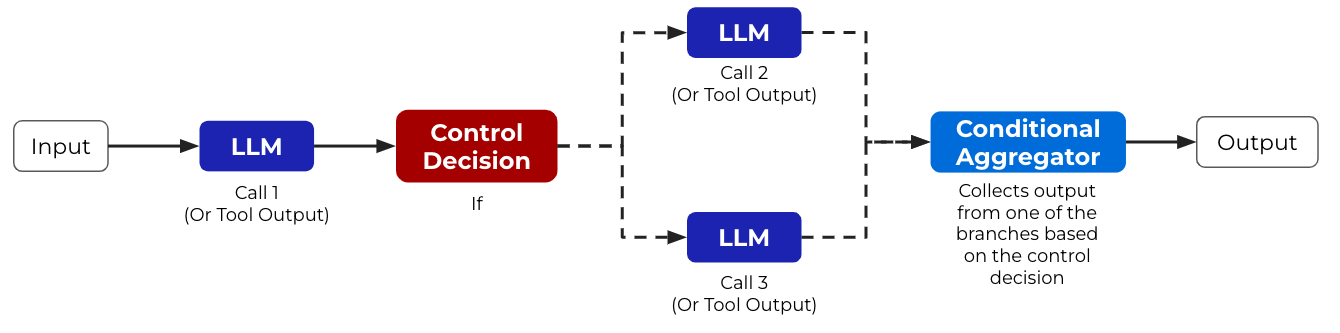

## Business Objective


Build an automated system that acts like an intelligent switchboard for customer service queries. It will receive a customer's query, use an LLM to classify the query's intent (e.g., general question, refund request, technical support), and then route the query to a specialized "handler" node designed to address that specific type of request. Each handler will then generate an appropriate response. This demonstrates how LangGraph can manage workflows where the path of execution depends on an initial analysis of the input.

As with the previous two workflows let us begin by defining our state objects that will be shared by the workflow.

In [51]:
class QueryClassification(BaseModel):
    """Schema for the query classification result."""
    category: Literal["general_query", "refund_request", "technical_support", "unknown"] = Field(
        description="The classified category of the customer query."
    )
    reasoning: str = Field(description="Brief explanation for the classification decision.")

In [52]:
class RouterState(TypedDict):
    """
    Represents the state of our query routing workflow.
    """
    customer_query: str                 # The incoming query from the customer
    query_category: str | None          # The category assigned by the classifier node
    response: str | None                # The final response generated by the handler node
    error_message: str | None           # To store potential errors

In the above code block:
- The `QueryClassification` Pydantic `BaseModel` defines the strict structure we expect back from the LLM when it classifies the query. Using `Literal` ensures the category field must be one of the specified strings ("general_query", "refund_request", "technical_support", or "unknown"), preventing unexpected classification results. Including reasoning helps in debugging and understanding the LLM's decision.
- The `RouterState` `TypedDict` defines the data container for our workflow. It holds the initial `customer_query`, the `query_category` determined by the classifier, the final `response` generated by one of the handlers, and an optional `error_message`.

## Define workflow nodes

In [53]:
def classify_query(state: RouterState) -> dict:
    """Classifies the customer query into predefined categories."""

    print("---CLASSIFYING QUERY---")
    query = state['customer_query']

    classification_system_message = """
    You are an expert query classifier. Analyze the customer query and classify it into one of the following categories:
    - 'general_query' (e.g., asking about store hours, product availability),
    - 'refund_request' (e.g., asking for money back, returning an item),
    - 'technical_support' (e.g., problem using a product, website issue, troubleshooting), or
    - 'unknown' if it doesn't fit well.
    Respond ONLY with the required JSON format, including brief reasoning.
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", classification_system_message),
        ("human", "Customer Query: {query}")
    ])

    # Use structured output to get reliable classification
    classifier_chain = prompt | llm.with_structured_output(QueryClassification)

    try:
        classification_result: QueryClassification = classifier_chain.invoke({"query": query})
        print(f"Classification: {classification_result.category} (Reason: {classification_result.reasoning})")
        # Update the state with the classification result
        return {"query_category": classification_result.category}
    except Exception as e:
        print(f"Error during classification: {e}")
        # If classification fails, mark as unknown and log error
        return {"query_category": "unknown", "error_message": f"Classification failed: {e}"}

This node is the first crucial step after receiving the input. Its sole purpose is to determine the type of the `customer_query`.
- It retrieves the `customer_query` from the input state.
- It uses a carefully crafted `ChatPromptTemplate` instructing the LLM on the available categories and the need for structured JSON output.
- It leverages `llm.with_structured_output(QueryClassification)` to ensure the LLM's response adheres strictly to the `QueryClassification` schema (category and reasoning). This is vital for the routing logic that follows.
- Upon successful classification, it prints the result and returns a dictionary containing only the `query_category`. This dictionary will be merged into the main workflow state by LangGraph.
- Basic error handling is included; if the LLM call fails or produces invalid output (despite `with_structured_output`), it defaults the category to "unknown" and records an error message in the state.

Let us now build each of the specialized paths.

In [54]:
def handle_general_query(state: RouterState) -> dict:

    """Handles general information queries."""
    print("---HANDLING GENERAL QUERY---")

    query = state['customer_query']

    general_system_message = """
    You are a helpful customer service assistant. Provide a concise and friendly answer to the following general customer query.
    If you don't know the answer, politely say so and suggest how they might find it (e.g., check the FAQ page).
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", general_system_message),
        ("human", "{query}")
    ])

    response_chain = prompt | llm
    response = response_chain.invoke({"query": query})
    return {"response": response.content}

In [55]:
def handle_refund_request(state: RouterState) -> dict:

    """Handles refund request queries."""

    print("---HANDLING REFUND REQUEST---")

    query = state['customer_query']

    # In a real system, this might involve checking order status, refund policy lookup, etc.
    # Here, we use a specific prompt for the LLM.

    refund_system_message = """
    You are a customer service assistant specializing in returns and refunds. Respond empathetically to the customer's request.
    Explain the general refund process (e.g., needing order number, item condition, return timeframe).
    Do NOT promise a refund, but explain the steps involved.
    If specific details like order number are missing, politely request them.
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", refund_system_message),
        ("human", "{query}")
    ])

    response_chain = prompt | llm
    response = response_chain.invoke({"query": query})
    return {"response": response.content}

In [56]:
def handle_technical_support(state: RouterState) -> dict:

    """Handles technical support queries."""
    print("---HANDLING TECHNICAL SUPPORT---")

    query = state['customer_query']

    # In a real system, this might involve searching knowledge bases, running diagnostics, etc.

    technical_support_system_message = """
    You are a technical support specialist. Address the customer's technical issue. Ask clarifying questions if needed (e.g., device model, error messages).
    Offer initial troubleshooting steps. If the issue is complex, explain how to escalate the problem (e.g., contact advanced support).
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", technical_support_system_message),
        ("human", "{query}")
    ])

    response_chain = prompt | llm
    response = response_chain.invoke({"query": query})
    return {"response": response.content}

In [57]:
def handle_unknown_query(state: RouterState) -> dict:

    """Handles queries that couldn't be classified."""

    print("---HANDLING UNKNOWN QUERY---")

    query = state['customer_query']

    error = state.get('error_message') # Get error message if classification failed

    response_text = (f"Thank you for reaching out. We weren't able to categorize your specific request based on the query: '{query}'. "
                     f"{'Error during processing: ' + error + '. ' if error else ''}"
                     "Could you please rephrase your question or provide more details? You can also contact our support team directly at [support email/phone] or visit our help center at [link].")

    return {"response": response_text}


These functions represent the different specialized paths the workflow can take after classification. Each function is tailored to handle one specific `query_category`.

- They all retrieve the original `customer_query` from the state.
- Each uses a distinct `ChatPromptTemplate` with system instructions relevant to its category (general info, refunds, tech support). This guides the LLM to generate an appropriate response for that context.
- For simplicity in this example, they directly use an LLM chain `(prompt | llm)` to generate the response. In a real-world application, these nodes could involve more complex logic: calling external APIs (e.g., checking an order database for refunds), using specific tools (e.g., running a diagnostic script for tech support), or executing more complex chains.
- The `handle_unknown_query` node acts as a fallback, providing a generic response when classification fails or is uncertain. It also includes any error message captured during classification.
- Each handler node returns a dictionary containing only the final response, updating the corresponding field in the RouterState.

## Define conditional logic (router)

In [58]:
def route_query(state: RouterState) -> Literal["general", "refund", "technical", "unknown"]:

    """Determines the next node based on the classified query category."""

    print("---ROUTING QUERY---")

    category = state.get('query_category') # Use .get for safety

    if category == "general_query":
        print("Outcome: Routing to General Query Handler")
        return "general"
    elif category == "refund_request":
        print("Outcome: Routing to Refund Request Handler")
        return "refund"
    elif category == "technical_support":
        print("Outcome: Routing to Technical Support Handler")
        return "technical"
    else: # Includes None or "unknown"
        print("Outcome: Routing to Unknown Query Handler")
        return "unknown"

This function is the core of the routing pattern. It doesn't perform complex processing itself; instead, it acts as a decision-maker based on the output of the `classify_query` node.

- It reads the `query_category` from the current state. Using `.get()` ensures it handles cases where the category might not have been set (although our classifier aims to always set it, even to "unknown").
- It uses simple conditional logic (if/elif/else) to check the value of `query_category`.
- Based on the category, it returns a specific string literal ("general", "refund", "technical", or "unknown"). Crucially, these returned strings must exactly match the keys used in the `path_map` provided to `add_conditional_edges` later.

## Graph construction

In [59]:
# Define the workflow graph
workflow = StateGraph(RouterState)

# Add the nodes
workflow.add_node("classify_query", classify_query)
workflow.add_node("handle_general_query", handle_general_query)
workflow.add_node("handle_refund_request", handle_refund_request)
workflow.add_node("handle_technical_support", handle_technical_support)
workflow.add_node("handle_unknown_query", handle_unknown_query)

# Define the starting point
workflow.add_edge(START, "classify_query")

# Define the routing logic
workflow.add_conditional_edges(
    "classify_query",  # Branch decisions are made *after* classify_query
    route_query,       # The function that decides which branch to take
    {
        # Map the return values of route_query to the names of the next nodes
        "general": "handle_general_query",
        "refund": "handle_refund_request",
        "technical": "handle_technical_support",
        "unknown": "handle_unknown_query",
    }
)

# Define the end points for each branch
workflow.add_edge("handle_general_query", END)
workflow.add_edge("handle_refund_request", END)
workflow.add_edge("handle_technical_support", END)
workflow.add_edge("handle_unknown_query", END)

# Compile the graph into a runnable object
compiled_workflow = workflow.compile()

This code block assembles the workflow's structure using the nodes and the routing logic defined earlier.
- `StateGraph(RouterState)` initializes the graph builder with our state definition.
- `add_node()` registers each function (classifier and handlers) as a node with a unique string name.
- `add_edge(START, "classify_query")` sets the entry point: the workflow always begins with the classification step.
- `add_conditional_edges()` is the key implementation of the routing pattern.
    - It specifies that after the `classify_query` node finishes, the `route_query` function should be executed.
    - Notice the addition of a dictionary (`path_map`) in this code block compared to a similar conditional edge construction from the sequential workflow discussed earlier. This `path_map` provided tells LangGraph how to proceed based on the string returned by route_query. For example, if route_query returns "refund", the workflow transitions to the node named "handle_refund_request".
- `add_edge(..., END)` defines that after any of the handler nodes complete, the workflow should terminate successfully.
- `compile()` finalizes the graph structure, making it ready for execution.

In [66]:
graph = compiled_workflow.get_graph().draw_mermaid()
print(graph)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	classify_query(classify_query)
	handle_general_query(handle_general_query)
	handle_refund_request(handle_refund_request)
	handle_technical_support(handle_technical_support)
	handle_unknown_query(handle_unknown_query)
	__end__([<p>__end__</p>]):::last
	__start__ --> classify_query;
	handle_general_query --> __end__;
	handle_refund_request --> __end__;
	handle_technical_support --> __end__;
	handle_unknown_query --> __end__;
	classify_query -. &nbsp;general&nbsp; .-> handle_general_query;
	classify_query -. &nbsp;refund&nbsp; .-> handle_refund_request;
	classify_query -. &nbsp;technical&nbsp; .-> handle_technical_support;
	classify_query -. &nbsp;unknown&nbsp; .-> handle_unknown_query;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



the above mermaid code can be visualised here https://mermaid.live/edit#pako:eNp9k99umzAUxl_FcqUpkYDxp0Bwqtwsj7CrlQo5YIM1YjNjr8uivHsNoWksklzBsX_n8_k-8BGWoiIQQdd1c14KTlmNcg4AbcV72WCpxgqAUsu_BIGWcYJlzke8lrhrwM_tOue5KopeGbwoFq8v3eZSvXzvNm9LhBBlslcDWLa47xk9FH80kYeFXS4HosG8aklRE04kbifu1uI1LQnVvDIPs9Orxc3Va16RsuGsNFK97johLy2zjesuzX9z8c7tmazF5TkMYk79jGJ8vwRh_CorMOC6G2DHsL4Xw8hOiuu77u9RM2v3QMvRDLJnBa4HvvFd362nSc8F8EzXLQsPJc4-5gq2v4cSF5NzlZn_h0JTCHMZK50viS2hoCIU61YBytoWPdGQ-pQ6w6VxG8LqRqHAC62G8VqMuCs6XDJ1QL4FDL_LJLeju4SWZpdDB9aSVRApqYkD90Tu8VDC43Bbc6gasic5ROZ1miiHOT-Ztg7zX0LsPzul0HUDEcVtbyrdVViRLcPmZn8h5sMT-UNoriCKRwWIjvAfRM_Zysue0yCL0jiLV-nKgQeIwiD0ojiKV34Q-GEShenJgf_HM30v8bMkjJLAz9LIIOHpA-9lnrc

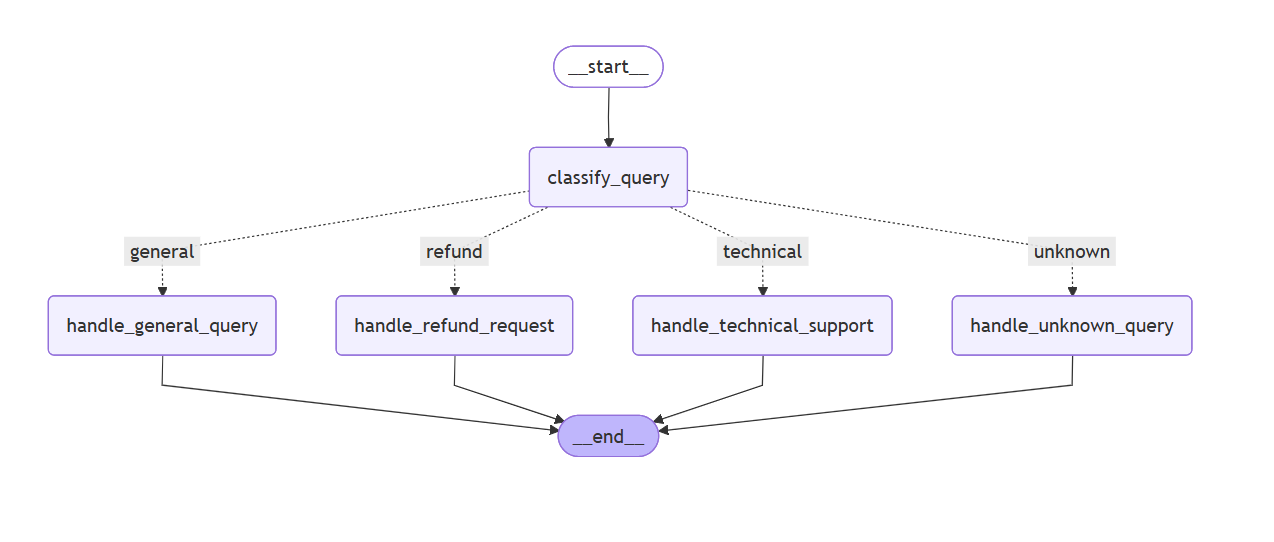

## Workflow execution

In [67]:
# Example Queries
query_general = "What are your store hours on Sunday?"
query_refund = "Hi, I received order #X123 and the item is defective. I'd like to return it for a refund."
query_tech = "I can't log in to my account on your website, the password reset link isn't working."
query_unknown = "Tell me about the weather today." # Intentionally off-topic

queries = [query_general, query_refund, query_tech, query_unknown]

In [68]:
for query in queries:
    print(f"\n--- RUNNING WORKFLOW FOR QUERY: '{query}' ---")
    initial_state = {"customer_query": query}
    # Invoke the workflow - it will follow the routed path
    final_state = compiled_workflow.invoke(initial_state)

    print("\n--- FINAL RESPONSE ---")
    print(final_state.get('response', 'No response generated.'))
    if final_state.get('error_message'):
         print(f"\nError recorded: {final_state.get('error_message')}")
    print("-" * 30)


--- RUNNING WORKFLOW FOR QUERY: 'What are your store hours on Sunday?' ---
---CLASSIFYING QUERY---
Classification: general_query (Reason: The user is asking about store hours, which is a typical general information request.)
---ROUTING QUERY---
Outcome: Routing to General Query Handler
---HANDLING GENERAL QUERY---

--- FINAL RESPONSE ---
Hi there! I’m not sure which specific store you’re asking about, but most of our locations are open on Sundays from **9 am – 6 pm**. To get the exact hours for your nearest store, please check the “Store Locator” on our website or give the store a quick call. If you need any more help, just let me know!
------------------------------

--- RUNNING WORKFLOW FOR QUERY: 'Hi, I received order #X123 and the item is defective. I'd like to return it for a refund.' ---
---CLASSIFYING QUERY---
Classification: refund_request (Reason: The customer explicitly states the item is defective and requests to return it for a refund, which matches the refund request cate

<font size=6; color='blue'> **Happy Learning!** </font>
___